# Group 12
## Shubhankar Mondal-22456
## Trishit Mukherjee -22590
## Abhigyan Martin Ninama -

# Vision Tasks

1. Cnn

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Conv:
    lambda_regularize_l2 = 0
    lambda_regularize_l1 = 0
    learning_rate = 0.1
    def __init__(self,in_ch,out_ch,size=3,padding=0,stride = 1):
        self.in_channels = in_ch
        self.out_channels = out_ch
        self.filter_size = size
        self.filters = np.random.randn(out_ch,in_ch, size, size)
        self.padding = padding
        self.stride = stride
        
    def iterate_regions(self,inp):
        stride = self.stride
        s= self.filter_size
        c_in,h,w = inp.shape   
        
        for i in range(0,h-s,stride):
            for j in range(0,w-s,stride):
                im_region = inp[:,i:i+s, j:j+s]
                yield im_region, i, j
                
    def forward(self,inp):
        
        k = self.filter_size
        p = self.padding
        s = self.stride
        _,h,w = inp.shape
       
        out_ch,in_ch,_,_ = self.filters.shape
        h = int((h-k+2*p)/s)+1
        w = int((w-k+2*p)/s)+1
        inp = np.pad(inp, pad_width=p)
        self.last_input = inp
        output = np.zeros((out_ch,h,w))
        
        
        for o in range(out_ch):   
            for wind,i,j in self.iterate_regions(self.last_input): 
                output[o,i,j]=np.sum(self.filters[o]*wind)      
        self.last_output = output
        return output
        
    def backprop(self,dl_dout):
        """
        dl_out is matrix with elements dl_out[cout] for cout channel
        dilated_dl_dout is dilated version of dl_dout array
        
        """
        filt_cout,filt_cin,filt_row,filt_col = self.filters.shape
        dilated_dl_dout = self.dilation4d(dl_dout)
        dl_df = np.zeros(self.filters.shape)
        dl_dx = np.zeros(self.last_input.shape)
        _,dil_row,dil_col = dilated_dl_dout.shape
        for co in range(filt_cout):
            for ci in range(filt_cin):
                for i in range(filt_row-dil_row+1):
                    for j in range(filt_col-dil_col+1):
                        dl_df[co,ci,i,j] += np.sum(self.last_input[ci,i:i+dil_row,j:j+dil_col]*dilated_dl_dout[co])
        padded_dl_dout = np.pad(dilated_dl_dout, ((0,0),(self.filter_size-1,  self.filter_size-1), ( self.filter_size-1,  self.filter_size-1)))
        
        cin,row,col = self.last_input.shape
        
        for k in range(cin):
            for i in range(row):
                for j in range(col):
                    for co in range(filt_cout):
                        dl_dx[k,i,j] += np.sum(padded_dl_dout[co,i:i+filt_row,j:j+filt_col]*self.filters[co,k,::-1,::-1])
        l1 = np.full(self.filters.shape,self.lambda_regularize_l1)
        mask_l1 = np.where(self.filters >0, l1, -l1)        
        self.filters=self.filters-self.learning_rate*(dl_df+self.filters*self.lambda_regularize_l2+mask_l1)
        return dl_dx
        
    def dilation4d(self,arr):
        c,row,col=arr.shape
        dilated = np.zeros((c,row+(row-1)*(self.stride-1),col+(col-1)*(self.stride-1)))
        dilated[:,::self.stride,::self.stride]=arr[:,:,:]
        return dilated
        

In [3]:
class Maxpool:
    def __init__(self,ksize=2,stride=2,padding=0):
        self.filter_size = ksize
        self.stride=stride
        self.pad_width=padding

    def iterate_regions(self,inp):
        stride = self.stride
        size= self.filter_size
        h,w = inp.shape   
        for i in range(0,h-size+1,stride):
            for j in range(0,w-size+1,stride):
                im_region = inp[i:i+size,j:j+size]
                yield im_region, int(i/stride), int(j/stride)
    
    def forward(self,inp):
        C,H,W = inp.shape
        inp = np.pad(inp, ((0,0),(self.pad_width, self.pad_width), (self.pad_width, self.pad_width)),'edge')
        self.last_input = inp
        out_h = int((H-self.filter_size+2*self.pad_width)/self.stride)+1
        out_w = int((W-self.filter_size+2*self.pad_width)/self.stride)+1
        out = np.zeros((C,out_h,out_w)) 
        
        for c in range(C):   
            for wind,i,j in self.iterate_regions(self.last_input[c]): 
                out[c,i,j]=np.max(wind)
        
        self.last_output=out
        return out
                    
    def backprop(self,dl_dout):
        stride = self.stride
        dl_din = np.zeros(self.last_input.shape)
        C,H,W = self.last_input.shape
        wind_row = wind_col = self.filter_size
        
        for c in range(C):   
            for wind,i,j in self.iterate_regions(self.last_input[c]): 
                for row in range(wind_row):
                    for col in range(wind_col):
                        if self.last_output[c,i,j]==wind[row,col]:
                            dl_din[c,i*stride+row,j*stride+col] = dl_dout[c,i,j]
    
        return dl_din
        
        

In [4]:
class Relu:
    def __init__(self):
        return None
    def forward(self,inp):  
        self.last_input = inp
        self.last_output = np.where(inp >0, inp, 0)
        return self.last_output
    
    def backprop(self,dl_dout):
        dl_din = np.where(self.last_input>0,dl_dout,0)
        return dl_din
        

In [5]:
class Flatten:
  def __init__(self):
    self.orig_shape=None
  def forward(self,x):
    self.orig_shape = x.shape
    return x.reshape([-1,1])

  def backprop(self,x):
    op=x.reshape(self.orig_shape)
    return op

In [6]:
class Dense:
  def __init__(self,inp,out):
    self.inp=inp
    self.out=out
    self.w=np.random.rand(out,inp)
    self.store=None

  def forward(self,x):
    self.store=x
    op=(self.w)@x
    return op

  def backprop(self,dx,stp=0.01): 
    z=self.w.T@dx
    self.w=self.w-stp*dx@(self.store).T
    return z

In [7]:
class Softmax:
  def __init__(self):
    self.store=None

  def forward(self,x):
    exps = np.exp(x-np.max(x))
    op = exps/np.sum(exps)
    self.store=op
    return op

  def backprop(self,x):
    softmax_derivative = np.diagflat(self.store) - np.dot(self.store, self.store.T)
    grad = softmax_derivative@x
    return grad

In [8]:
class ReLU:
  def __init__(self):
    self.map=None

  def forward(self,x):
    mask = (x > 0)
    self.map = mask.astype(int)
    op=self.map*x
    return op

  def backprop(self,x): 
    return x*self.map

In [9]:
def cross_entropy_loss(true_class,predicted_y):
    return -np.log(predicted_y[true_class])

def gradient(true_class,predicted_y):
    dl_dout = np.zeros(predicted_y.shape)
    dl_dout[true_class] = -1/(predicted_y[true_class]+0.000001)
    return dl_dout
def calculate_accuracy(true_class, predicted_y):
  accuracy = np.mean(np.equal(true_class, predicted_y))
  return accuracy


In [27]:
class Cnn:
    def __init__(self, regularise:str):
        if regularise=='l2':
            self.l1 = Conv(3,16,10,0,1)
            self.l1.lambda_regularise_l2 =1
            
        else:
            self.l1 = Conv(3,16,10,0,1)
        self.l2 = Maxpool(7,7,1)
        self.l3 = Relu()
        self.l7 = Flatten()
        self.l10=Dense(64,10)
        self.l11=ReLU()
        self.l12=Softmax()

    def forward(self,x):
        out = self.l1.forward(x)
        out = self.l2.forward(out)  
        out = self.l3.forward(out)    
        out = self.l7.forward(out) 
        out = self.l10.forward(out) 
        out = self.l11.forward(out) 
        out = self.l12.forward(out)     
        return out
    
    def backprop(self,dl_dout):
        dl_din = self.l12.backprop(dl_dout)
        dl_din = self.l11.backprop(dl_din) 
        dl_din = self.l10.backprop(dl_din)  
        dl_din = self.l7.backprop(dl_din)
        dl_din = self.l3.backprop(dl_din)
        dl_din = self.l2.backprop(dl_din)
        dl_din = self.l1.backprop(dl_din)

    def train(self,train_x,train_y,valx,valy ):
        epoch = 2
        val_acc = []
        for j in range(epoch):
            predicted_y = np.zeros((1000,),dtype = int)
            for i in range(1000):
                out = self.forward(train_x[i])
                predicted_y[i] = np.argmax(out)
                dl_dout = gradient(train_y[i],out)
                self.backprop(dl_dout)
            print("epoch ",j," complete")      
            
    def test(self,test_x,test_y):
        predicted_y = np.zeros(test_y.shape)
        for i in range(len(test_x)):  
            out = self.forward(test_x[i])
            predicted_y[i] = np.argmax(out)     
        acc = calculate_accuracy(test_y,predicted_y)
        f1 = f1_score(test_y, predicted_y)
        print("accuracy is ",acc)
        print("f1_macro score is ",f1,)

In [28]:

data_x = np.load('datatree.npz')['data']
data_y = np.load('datatree.npz')['labels']
train_x =np.array(data_x,dtype = 'float')/255.0
train_x = np.transpose(train_x,(0,3,1,2))

In [29]:
labels = dict({'cane':0,
               'cavallo':1,
               'elefante':2,
               'farfalla':3,
               'gallina':4,
               'gatto':5,
               'mucca':6,
               'pecora':7,
               'ragno':8,
               'scoiattolo':9})
y = np.zeros(len(data_y),dtype = int)
for i in range(data_y.shape[0]):
    y[i] = labels[data_y[i]]
train_y=y

In [31]:
def f1_score(y_true, y_pred):
    if len(y_true) != len(y_pred):
        raise ValueError("y_true and y_pred must have the same length.")
    
    unique_labels = list(set(y_true))
    tp_sum = 0
    fp_sum = 0
    fn_sum = 0

    f1_per_class = []
    for label in unique_labels:
        true_p = sum(t == p == label for t, p in zip(y_true, y_pred)) 
        false_p = sum(p == label for p in y_pred if p not in y_true) 
        false_n = sum(t == label for t in y_true if t not in y_pred)  

        precision = true_p / (true_p + false_p) if (true_p + false_p) > 0 else 0
        recall = true_p / (true_p + false_n) if (true_p + false_n) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
        f1_per_class.append(f1)
        tp_sum += true_p
        fp_sum += false_p
        fn_sum += false_n

    precision_macro = tp_sum / (tp_sum + fp_sum) if (tp_sum + fp_sum) > 0 else 0
    recall_macro = tp_sum / (tp_sum + fn_sum) if (tp_sum + fn_sum) > 0 else 0
    f1_macro = 2 * (precision_macro * recall_macro) / (precision_macro + recall_macro) if (precision_macro + recall_macro) > 0 else 0
    return f1_macro

In [32]:
def randomised_trainingset(setx,sety):
    num=np.array([4863, 2623, 1446, 2112, 3098, 1668, 1866, 1820, 4821, 1862])
    total,c,h,w = setx.shape
    train = int(total*0.6)
    val = int(total*0.1)
    test = total-val-train
    
    trainX = np.zeros((train,c,h,w))
    trainY = np.zeros(train,dtype=int)
    valX = np.zeros((val,c,h,w))
    valY = np.zeros(val,dtype=int)
    testX = np.zeros((test,c,h,w))
    testY = np.zeros(test,dtype=int)
     
    
    indices =  np.random.permutation(total)
    trainX = np.take(setx, indices[:train],axis=0)
    trainY = np.take(sety, indices[:train])
    valX = np.take(setx, indices[train:train+val],axis=0)
    valY = np.take(sety, indices[train:train+val])
    testX = np.take(setx, indices[train+val:],axis=0)
    testY = np.take(sety, indices[train+val:])
    
    
    return trainX,trainY,valX,valY,testX,testY
          

In [33]:
train_x,train_y,valx,valy,test_x,test_y = randomised_trainingset(train_x,train_y)
model1 = Cnn(regularise = 'none')
model2 = Cnn(regularise = 'l0')

In [35]:

model2.train(train_x,train_y,valx,valy)

epoch  0  complete
epoch  1  complete


In [36]:
model2.test(test_x[:500],test_y[:500])

accuracy is  0.171
f1_macro score is  0.2920580700256191


In [37]:
#without regularization
model1.train(train_x,train_y,valx,valy)
model1.test(test_x,test_y)

epoch  0  complete
epoch  1  complete
accuracy is  0.11495862507956715
f1_macro score is  0.20621146380452157


2) Using PCA to reduce the feature dimensions and apply MLP on reduced features.and later Comparing the results with the CNN.

In [69]:
class PCA:
    def __init__(self, dim):
        self.num_components = dim
        self.mean = None
        self.components = None
        self.variance_share = None
    
    def fit(self, x):

        self.mean = np.mean(x)
        x-=self.mean
        cov = np.cov(x.T)
        eval, evector = np.linalg.eig(cov)
        
        sort_idx = np.argsort(eval)[::-1]
        values = eval[sort_idx]
        vectors = evector[:,sort_idx]
        self.components = vectors[:,:self.num_components]
        self.variance_share = np.sum(values[:self.num_components])/np.sum(values)
        
    def transform(self, x):
        x -=self.mean
        return np.dot(x,self.components)

In [70]:
#loading the training data

data_x = np.load('25x25.npz')['data']
data_y = np.load('25x25.npz')['labels']
train_x =np.array(data_x,dtype = 'float')/255.0
train_x.shape



(26179, 25, 25, 3)

In [71]:
train_x = np.reshape(train_x, (26179, 25*25*3))

In [74]:
def randomised_trainingset(setx,sety):
    total,r = setx.shape
    train = int(total*0.8)
    test = total-train
    
    trainx = np.zeros((train,r))
    trainy = np.zeros(train,dtype=int)
    testx = np.zeros((test,r))
    testy = np.zeros(test,dtype=int)
    
    indices =  np.random.permutation(total)
    trainx = np.take(setx, indices[:train],axis=0)
    trainy = np.take(sety, indices[:train])
    testx = np.take(setx, indices[train:],axis=0)
    testy = np.take(sety, indices[train:])
    
    
    return trainx,trainy,testx,testy
        

In [75]:
train_x,train_y,test_x,test_y = randomised_trainingset(train_x,train_y)


In [76]:
trainx = train_x[:2000]
trainy = train_y[:2000]
testx= test_x[:1000]
testy = test_y[:1000]

Applying PCA to reduce dimensions to 30

In [77]:
pca = PCA(30) 
pca.fit(trainx)
print(f"Explained variance: {pca.variance_share:.4f}")
trainx =pca.transform(trainx)
print(trainx.shape)

Explained variance: 0.7041
(2000, 30)


In [78]:
testx = pca.transform(testx)

In [83]:
def one_hot_encode(labels):
    unique_labels = np.unique(labels)
    num_labels = len(unique_labels)
    encoding = np.zeros((len(labels), num_labels), dtype=int)
    for i, label in enumerate(labels):
        index = np.arange(num_labels)[unique_labels == label][0]
        encoding[i, index] = 1
    return encoding
testx = testx/255.0
trainy = one_hot_encode(trainy).T
testy = one_hot_encode(testy).T

In [86]:
print(f'Train x shape:{trainx.shape}')
print(f'Test x shape:{testx.shape}')
print(f'Train y shape:{trainy.shape}')
print(f'Test y shape:{testy.shape}')

Train x shape:(2000, 30)
Test x shape:(1000, 30)
Train y shape:(10, 2000)
Test y shape:(10, 1000)


In [87]:
trainx = trainx.T
testx = testx.T

Using MLP(alrady done in the 2nd assignment)

In [88]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def softmax(x):
    shifted_x = x - np.max(x, axis=0, keepdims=True) 
    exp_scores = np.exp(shifted_x)
    softmax_probs = exp_scores / np.sum(exp_scores, axis=0, keepdims=True)
    return softmax_probs

def initialize_parameters(input_size, hidden_sizes, output_size):
    np.random.seed(0)
    parameters = {}
    prev_size = input_size
    for i, hidden_size in enumerate(hidden_sizes):
        parameters[f'W{i+1}'] = np.random.randn(hidden_size, prev_size) * np.sqrt(1/prev_size)
        prev_size = hidden_size
    parameters[f'W{len(hidden_sizes)+1}'] = np.random.randn(output_size, prev_size) * np.sqrt(1/prev_size)
    return parameters
def update_parameters(parameters, gradients, learning_rate):
    for key in parameters.keys():
        parameters[key] -= learning_rate * gradients[f'd{key}']
    return parameters

def forward_propagation_multiclass(X, parameters):
    temp = {'A0': X}
    for i, key in enumerate(parameters.keys()):
        W = parameters[key]
        Z = np.dot(W, temp[f'A{i}'])
        if i < len(parameters) - 1:
            A = relu(Z)
        else:
            A = softmax(Z)
        temp[f'Z{i+1}'] = Z
        temp[f'A{i+1}'] = A
    return temp

def cross_entropy_loss(Y, Y_pred):
    m = Y.shape[1]
    epsilon = 1e-10 
    Y_pred = np.clip(Y_pred, epsilon, 1 - epsilon)
    loss = -1/m * np.sum(Y * np.log(Y_pred))
    return loss

def backward_propagation_multiclass(X, Y, parameters, temp):    
        gradients = {}
        dZ = temp[f'A{len(parameters)}'] - Y 
        for i in range(len(parameters), 0, -1):
            A_prev = temp[f'A{i-1}']
            gradients[f'dW{i}'] = np.dot(dZ, A_prev.T)
            if i > 1:
                W = parameters[f'W{i}']
                dZ = np.dot(W.T, dZ) * relu_derivative(temp[f'Z{i-1}'])
        return gradients

def predict_multiclass(X, parameters):
    temp = forward_propagation_multiclass(X, parameters)
    final_output = temp[f'A{len(parameters)}']
    predictions = np.argmax(final_output, axis=0)
    return predictions

def train_multiclass(X, Y, input_size, hidden_sizes, output_size, learning_rate, num_iterations, batch_size):
    parameters = initialize_parameters(input_size, hidden_sizes, output_size)
    for i in range(num_iterations):
        for j in range(0, X.shape[1], batch_size):
                X_batch = X[:, j:j+batch_size]
                Y_batch = Y[:, j:j+batch_size]
                temp = forward_propagation_multiclass(X_batch,parameters)
        loss_ce = cross_entropy_loss(Y_batch, temp[f'A{len(parameters)}'])
        gradients = backward_propagation_multiclass(X_batch, Y_batch, parameters, temp)
        parameters = update_parameters(parameters, gradients, learning_rate)
        if i % 100 == 0:
            print(f'Iteration {i}, Loss: {loss_ce}')
    return parameters

In [92]:
hidden_sizes = [128,128,256]
input_size = 30
output_size = 10
parameters = train_multiclass(trainx,trainy, input_size, hidden_sizes, output_size, learning_rate=0.001, num_iterations=1000, batch_size=32)

predictions = predict_multiclass(testx, parameters)

accuracy = np.mean(predictions == testy)
print(f"Accuracy on testing data: {accuracy*100}%")

Iteration 0, Loss: 3.67718533773981
Iteration 100, Loss: 1.3045469194540953
Iteration 200, Loss: 0.9074840612002326
Iteration 300, Loss: 0.635041076080527
Iteration 400, Loss: 0.46273705744185956
Iteration 500, Loss: 0.3472547012097944
Iteration 600, Loss: 0.2662656433374766
Iteration 700, Loss: 0.21007715063439175
Iteration 800, Loss: 0.1701377502550348
Iteration 900, Loss: 0.14096663146880112
Accuracy on testing data: 36.980000000000004%


3. Self attention on animal dataset

In [240]:
import os
from PIL import Image
def load_images(directory):
    images = []
    labels = []
    label_names = os.listdir(directory)
    label_map = {name: idx for idx, name in enumerate(label_names)}

    for label in label_names:
        class_dir = os.path.join(directory, label)
        for image_file in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_file)
            image = Image.open(image_path)
            image = image.resize((32, 32))
            image = image.convert('RGB') 
            image = np.array(image)
            images.append(image)
            labels.append(label_map[label])

    images = np.array(images)
    labels = np.array(labels)
    return images, labels, label_map

images, labels, label_map = load_images('/data/home/shubhankar/PRNN_Assignment/PRNN_Assignment_3/raw-img')

In [241]:
flattened_images = images.reshape(images.shape[0], -1)
print(flattened_images[0].shape)

(3072,)


In [243]:
pca_model = PCA(dim=1000)  
pca_model.fit(flattened_images)
pca_transformed = pca_model.transform(flattened_images)
print("PCA Transformed Shape:", pca_transformed.shape)

PCA Transformed Shape: (26179, 1000)


In [247]:
import random
combined_list = list(zip(pca_transformed, labels))
random.shuffle(combined_list)

final_animal_data = [pair[0] for pair in combined_list]
final_label = [pair[1] for pair in combined_list]

In [248]:
final_label

[9,
 7,
 0,
 5,
 9,
 7,
 9,
 1,
 9,
 7,
 9,
 7,
 4,
 3,
 3,
 4,
 3,
 0,
 7,
 0,
 7,
 9,
 4,
 0,
 2,
 2,
 2,
 7,
 7,
 7,
 2,
 9,
 6,
 8,
 5,
 2,
 0,
 8,
 8,
 7,
 2,
 2,
 0,
 0,
 5,
 2,
 0,
 5,
 0,
 9,
 3,
 4,
 5,
 7,
 9,
 9,
 5,
 5,
 0,
 9,
 5,
 7,
 1,
 7,
 2,
 2,
 0,
 9,
 8,
 9,
 0,
 2,
 9,
 7,
 4,
 9,
 0,
 5,
 9,
 3,
 1,
 0,
 4,
 8,
 9,
 9,
 7,
 2,
 5,
 9,
 9,
 3,
 6,
 6,
 0,
 5,
 9,
 2,
 9,
 2,
 9,
 4,
 0,
 8,
 2,
 4,
 8,
 0,
 1,
 9,
 3,
 8,
 0,
 6,
 9,
 1,
 8,
 0,
 7,
 0,
 5,
 5,
 9,
 9,
 3,
 9,
 0,
 6,
 6,
 5,
 9,
 0,
 0,
 0,
 0,
 4,
 3,
 2,
 1,
 9,
 0,
 7,
 0,
 1,
 0,
 9,
 0,
 0,
 1,
 5,
 4,
 3,
 1,
 0,
 2,
 1,
 7,
 2,
 0,
 9,
 6,
 9,
 9,
 0,
 9,
 5,
 9,
 5,
 7,
 0,
 9,
 6,
 9,
 9,
 0,
 7,
 0,
 2,
 0,
 9,
 9,
 8,
 7,
 0,
 2,
 9,
 0,
 8,
 0,
 0,
 1,
 9,
 0,
 8,
 0,
 6,
 2,
 6,
 0,
 7,
 0,
 3,
 8,
 7,
 1,
 3,
 7,
 4,
 0,
 9,
 1,
 7,
 9,
 0,
 3,
 3,
 5,
 6,
 5,
 2,
 1,
 2,
 1,
 5,
 1,
 9,
 7,
 7,
 0,
 5,
 5,
 9,
 0,
 7,
 0,
 9,
 8,
 2,
 9,
 0,
 4,
 9,
 7,
 1,
 9,
 9,
 9,
 7,
 5,
 1,


In [249]:
from sklearn.preprocessing import LabelBinarizer
one_hot_encoder=LabelBinarizer()
target=one_hot_encoder.fit_transform(final_label)
target

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [251]:
train_size=0.7
total_data_points=len(final_animal_data)
training_data_size=int(train_size*total_data_points)
X_train=final_animal_data[:training_data_size]
X_test=final_animal_data[training_data_size:]
y_train=target[:training_data_size]
y_test=target[training_data_size:]

In [253]:
X_train = np.array([np.abs(arr1) for arr1 in X_train])
X_test=np.array([np.abs(arr2) for arr2 in X_test])

In [255]:
X_train.shape

(18325, 1000)

In [262]:
y_train.shape

(18325, 10)

In [259]:

LEARNING_RATE=0.001
class SelfAttentionModule:
    def __init__(self,input_dim,d_k):
        self.input_dim=input_dim
        self.d_k=d_k
        self.W_Q=np.random.randn(self.input_dim,self.d_k) 
        self.W_K=np.random.randn(self.input_dim,self.d_k)
        self.W_V=np.random.randn(self.input_dim,self.d_k)
    def forward(self,X_train):
        self.X_train=X_train
        self.query_matrix=np.dot(X_train,self.W_Q)
        self.value_matrix=np.dot(X_train,self.W_V)
        self.key_matrix=np.dot(X_train,self.W_K)
        self.H_matrix=softmax(np.matmul(self.query_matrix,self.key_matrix.T)/np.sqrt(self.d_k))
        self.final_output=np.matmul(self.H_matrix,self.value_matrix)
        return self.final_output

    def backward(self,prev_gradient):
        self.W_V_grad = self.X_train.T @ self.H_matrix.T @ prev_gradient
        self.W_K_grad = (1/np.sqrt(self.d_k))* self.X_train.T @ (np.multiply(self.H_matrix,(prev_gradient @ self.value_matrix.T))).T @ (self.query_matrix- (self.H_matrix @ self.query_matrix))


        temp = np.multiply(self.H_matrix, np.matmul(prev_gradient, self.value_matrix.T)) - np.multiply(
            np.sum(np.multiply(self.H_matrix, np.matmul(prev_gradient, self.value_matrix.T)), axis=1), self.H_matrix)
        self.W_Q_grad = (1 / np.sqrt(self.d_k)) * np.matmul(np.matmul(self.X_train.T, temp), self.key_matrix)
        return self.W_K_grad,self.W_Q_grad,self.W_V_grad

In [219]:
attn=SelfAttentionModule(X_train.shape[1],d_k=50)
attn_res=attn.forward(X_train)

In [260]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.output_size = output_size

        self.W1 = np.random.randn(self.input_size, self.hidden_size1) * 0.01
        self.b1 = np.zeros((1, self.hidden_size1))
        self.W2 = np.random.randn(self.hidden_size1, self.hidden_size2) * 0.01
        self.b2 = np.zeros((1, self.hidden_size2))
        self.W3 = np.random.randn(self.hidden_size2, self.output_size) * 0.01
        self.b3 = np.zeros((1, self.output_size))

    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = relu(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = relu(self.z2)
        self.z3 = np.dot(self.a2, self.W3) + self.b3
        self.probs = softmax(self.z3)
        return self.probs

    def backward(self, X, y, learning_rate=0.01):
        m = X.shape[0]
        d_z3 = self.probs - y
        d_W3 = np.dot(self.a2.T, d_z3)
        d_b3 = np.sum(d_z3, axis=0, keepdims=True)
        d_a2 = np.dot(d_z3, self.W3.T)
        d_z2 = d_a2 * (self.a2 > 0)
        d_W2 = np.dot(self.a1.T, d_z2)
        d_b2 = np.sum(d_z2, axis=0, keepdims=True)
        d_a1 = np.dot(d_z2, self.W2.T)
        d_z1 = d_a1 * (self.a1 > 0)
        d_W1 = np.dot(X.T, d_z1)
        d_b1 = np.sum(d_z1, axis=0, keepdims=True)

        self.W1 -= learning_rate * d_W1
        self.b1 -= learning_rate * d_b1
        self.W2 -= learning_rate * d_W2
        self.b2 -= learning_rate * d_b2
        self.W3 -= learning_rate * d_W3
        self.b3 -= learning_rate * d_b3
        prev_gradient = np.dot(d_z1, self.W1.T)
        return prev_gradient


In [263]:
def calculate_accuracy(y_pred, y_test):
    y_pred = np.array(y_pred)
    y_test = np.array(y_test)
    y_pred_argmax = np.argmax(y_pred, axis=1)
    y_argmax=np.argmax(y_test,axis=1)
    correct_predictions = np.sum(y_pred_argmax==y_argmax)
    
    
    accuracy = correct_predictions / len(y_test)
    return accuracy

In [264]:
def cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-12
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    
    loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss


In [266]:
X_train=X_train[:2000,]
y_train=y_train[:2000,]
EPOCHS=10
LEARNING_RATE=0.001
attentionModel=SelfAttentionModule(input_dim=X_train.shape[1],d_k=50)
classifier=NeuralNetwork(50,128,128,10)
for epoch in range(EPOCHS):
    attention_output=attentionModel.forward(X_train)
    classifier_output=classifier.forward(attention_output)
    loss=cross_entropy_loss(y_train,classifier_output)
    classifier_prev_gradient=classifier.backward(attention_output,y_train,LEARNING_RATE)
    d_K,d_Q,d_V=attentionModel.backward(classifier_prev_gradient)
    attentionModel.W_Q -= LEARNING_RATE * d_Q
    attentionModel.W_K -= LEARNING_RATE * d_K
    attentionModel.W_V -= LEARNING_RATE * d_V
    print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {loss}')

Epoch 1/10, Loss: 0.5880213111072137
Epoch 2/10, Loss: 5.571859903555712
Epoch 3/10, Loss: 2.253329668564931
Epoch 4/10, Loss: 2.390187642647716
Epoch 5/10, Loss: 2.02161408058108
Epoch 6/10, Loss: 1.8585491768720614
Epoch 7/10, Loss: 1.508498502069039
Epoch 8/10, Loss: 1.6844345882086214
Epoch 9/10, Loss: 2.5646199787554416
Epoch 10/10, Loss: 2.6515230090909587


4. Kmeans on PCA features

In [157]:
def load_images(directory):
    images = []
    labels = []
    label_names = os.listdir(directory)
    label_map = {name: idx for idx, name in enumerate(label_names)}

    for label in label_names:
        class_dir = os.path.join(directory, label)
        for image_file in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_file)
            image = Image.open(image_path)
            image = image.resize((32, 32))
            image = image.convert('RGB')
            image = np.array(image)
            images.append(image)
            labels.append(label_map[label])

    images = np.array(images)
    labels = np.array(labels)
    return images, labels, label_map

images, labels, label_map = load_images('/content/drive/MyDrive/animal_1')

print(images[0].shape)
print(label_map)
print(labels)

(32, 32, 3)
{'cane': 0, 'cavallo': 1, 'elefante': 2, 'farfalla': 3, 'gallina': 4, 'gatto': 5}
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


Flatten the Images: Since PCA and K-means require a 2D array where each row is a sample and each column is a feature, flatten the images.

In [159]:
flattened_images = images.reshape(images.shape[0], -1) 
print(flattened_images[0].shape)

(3072,)


Normalize the Data

In [161]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_images = scaler.fit_transform(flattened_images)
print(scaled_images[0].shape)

(3072,)


In [164]:
pca_model = PCA(dim=1000)

pca_model.fit(flattened_images)
pca_transformed = pca_model.transform(flattened_images)
print("PCA Transformed Shape:", pca_transformed.shape)


PCA Transformed Shape: (240, 1000)


In [165]:
class KMeans:
    def __init__(self, n_clusters, max_iter, distance_type='euclidean'):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.distance_type = distance_type
        self.centers = None

    def fit(self, X):
        indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        self.centers = X[indices]

        for _ in range(self.max_iter):
            if self.distance_type == 'euclidean':
                distances = np.sqrt(((X - self.centers[:, np.newaxis])**2).sum(axis=2))
            elif self.distance_type == 'manhattan':
                distances = np.abs(X - self.centers[:, np.newaxis]).sum(axis=2)
            clusters = np.argmin(distances, axis=0)

            new_centers = np.array([X[clusters == k].mean(axis=0) for k in range(self.n_clusters)])
            if np.all(self.centers == new_centers):
                break
            self.centers = new_centers

    def predict(self, X):
        if self.distance_type == 'euclidean':
            distances = np.sqrt(((X - self.centers[:, np.newaxis])**2).sum(axis=2))
        elif self.distance_type == 'manhattan':
            distances = np.abs(X - self.centers[:, np.newaxis]).sum(axis=2)
        return np.argmin(distances, axis=0)


Test K-Means Clustering


In [166]:
kmeans_model = KMeans(n_clusters=6, max_iter=100, distance_type='euclidean')

kmeans_model.fit(pca_transformed)
clusters = kmeans_model.predict(pca_transformed)
print("Clusters:", clusters)
print("Original label:", labels)


Clusters: [1 4 1 2 5 1 2 1 1 1 3 4 1 3 2 4 3 1 4 1 1 3 4 2 5 4 2 1 4 1 1 3 1 1 5 1 1
 2 4 1 1 1 1 1 5 1 4 4 4 1 2 2 1 1 1 1 2 1 4 4 4 3 1 0 0 1 1 1 1 1 1 3 3 3
 5 3 2 2 2 2 2 2 3 1 1 3 1 4 0 3 1 3 1 3 3 3 0 3 4 1 1 1 1 1 1 0 4 0 1 1 1
 1 5 4 1 1 1 1 1 0 4 3 5 1 4 5 5 4 5 2 1 5 5 3 5 4 3 1 4 2 5 4 3 5 4 2 2 0
 2 4 2 2 5 4 2 1 5 2 2 4 2 3 4 4 1 5 1 5 4 2 1 4 5 2 5 1 2 5 1 0 3 2 4 5 4
 5 5 5 4 2 4 5 3 5 5 4 4 2 3 5 5 5 4 5 2 3 3 0 5 3 2 2 4 4 5 5 2 1 1 2 4 1
 0 3 4 5 4 5 5 4 5 5 5 2 2 5 3 2 5 1]
Original label: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5

In [167]:
frequency = {}

for number in clusters:
    if number in frequency:
        frequency[number] += 1
    else:
        frequency[number] = 1
for number, count in frequency.items():
    print(f"Number {number}: {count} times")

Number 1: 69 times
Number 4: 45 times
Number 2: 40 times
Number 5: 44 times
Number 3: 31 times
Number 0: 11 times


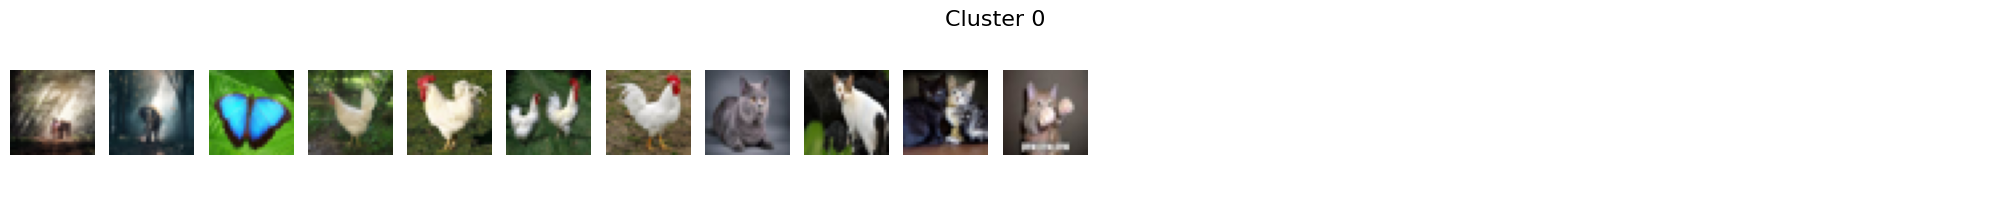

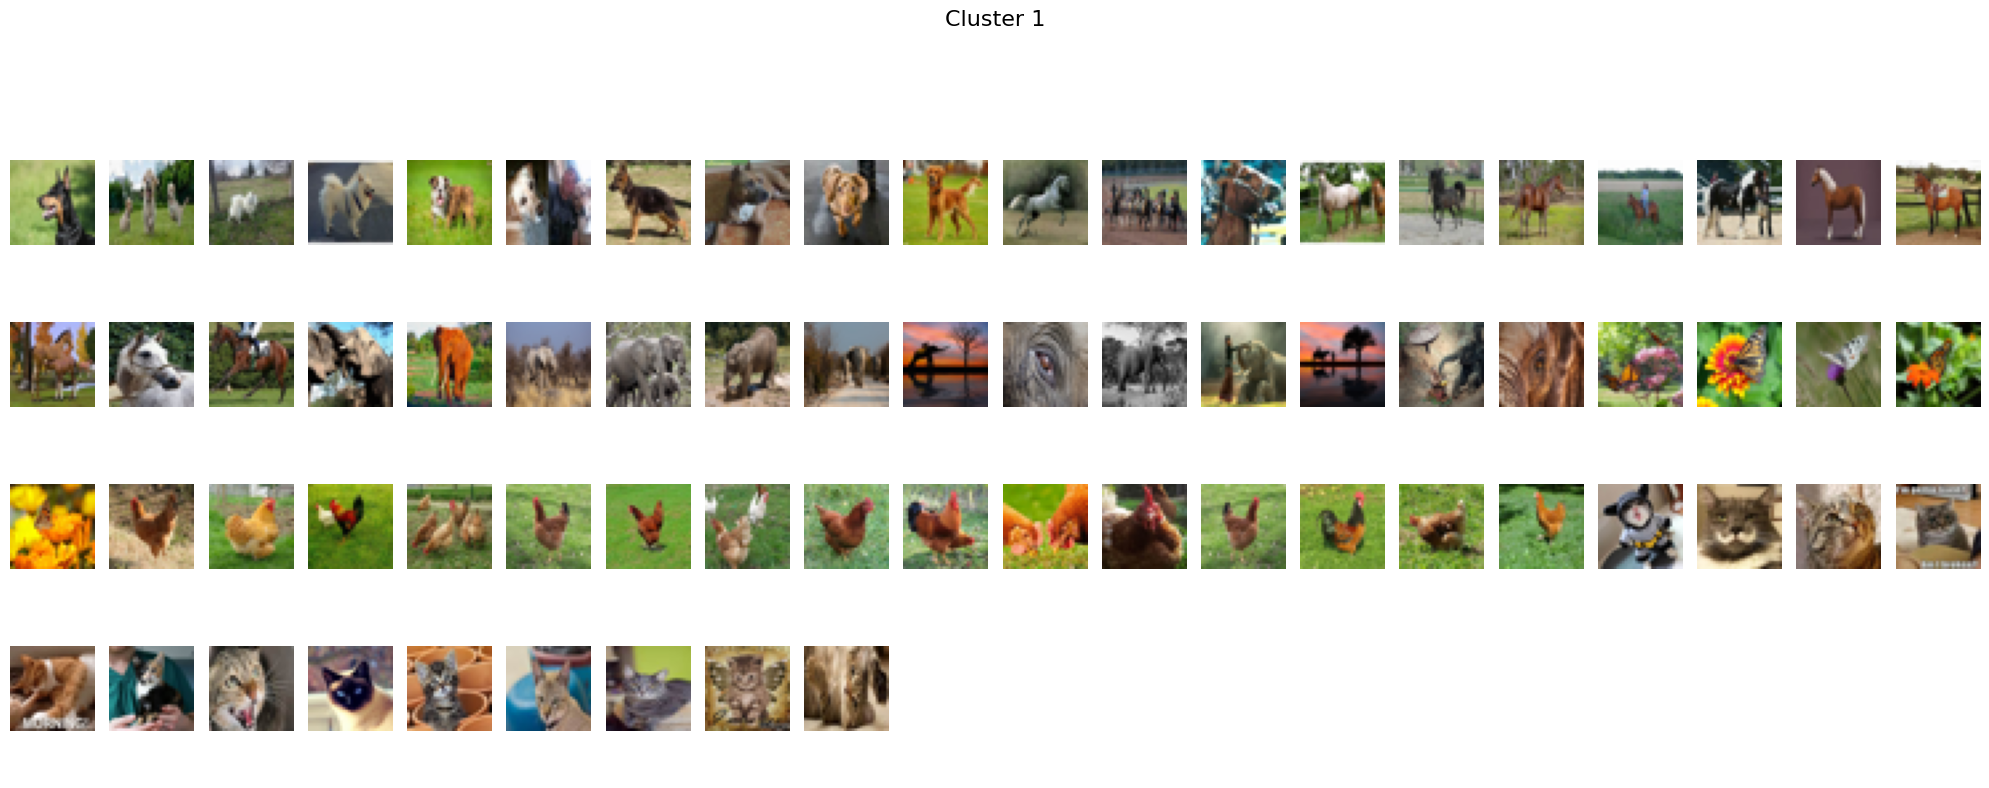

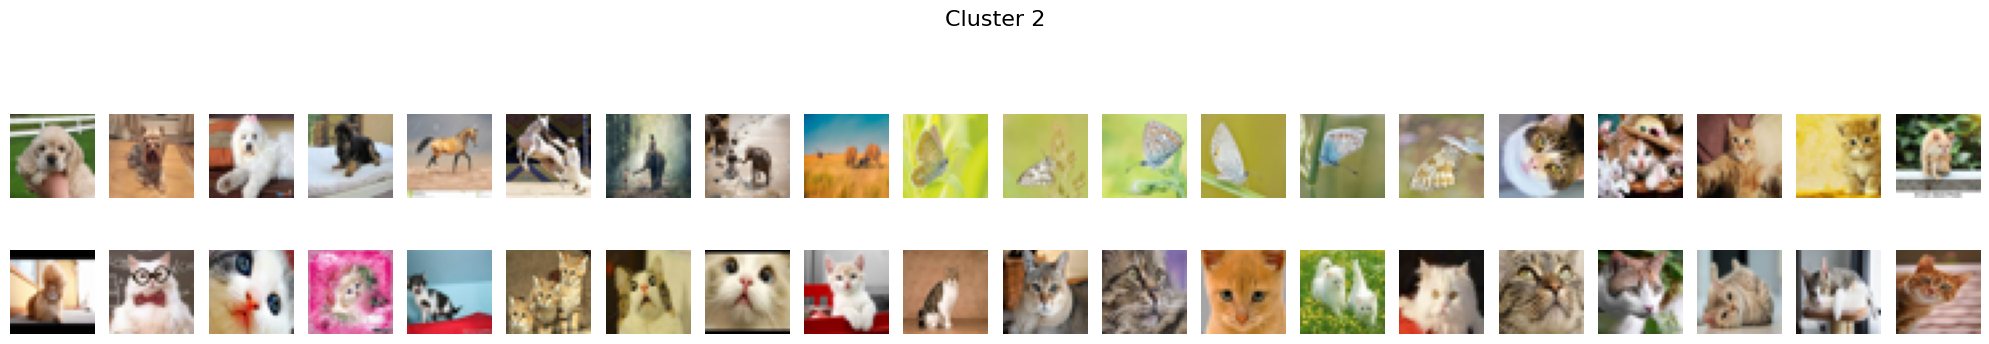

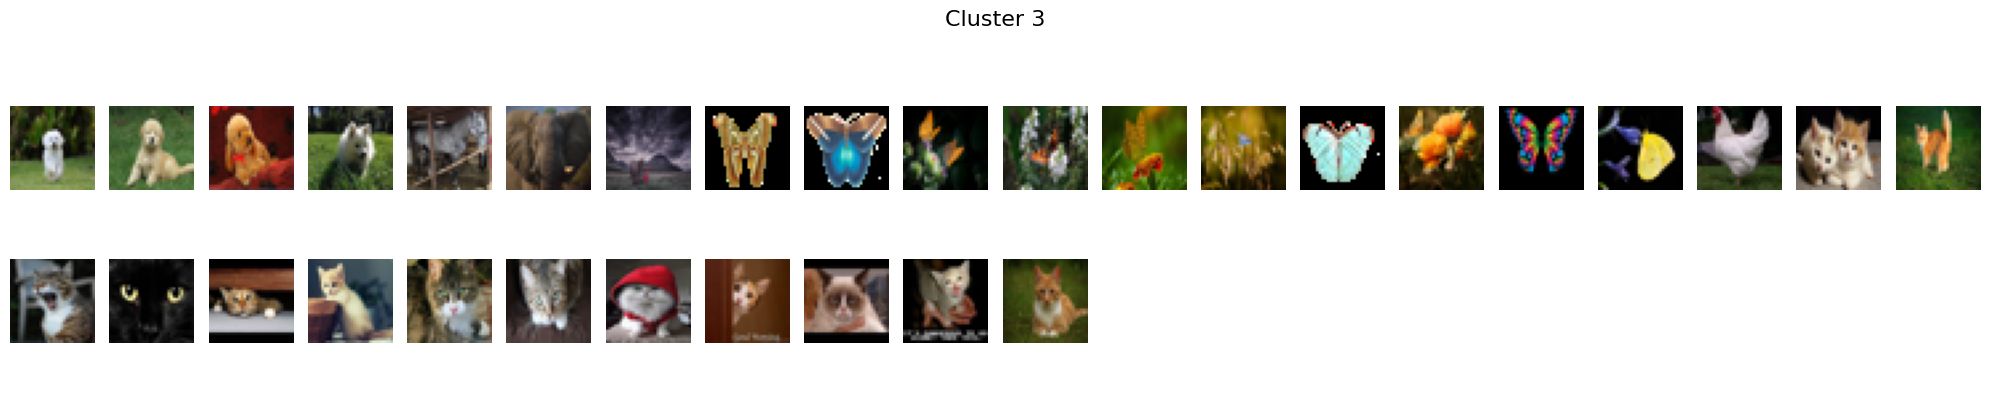

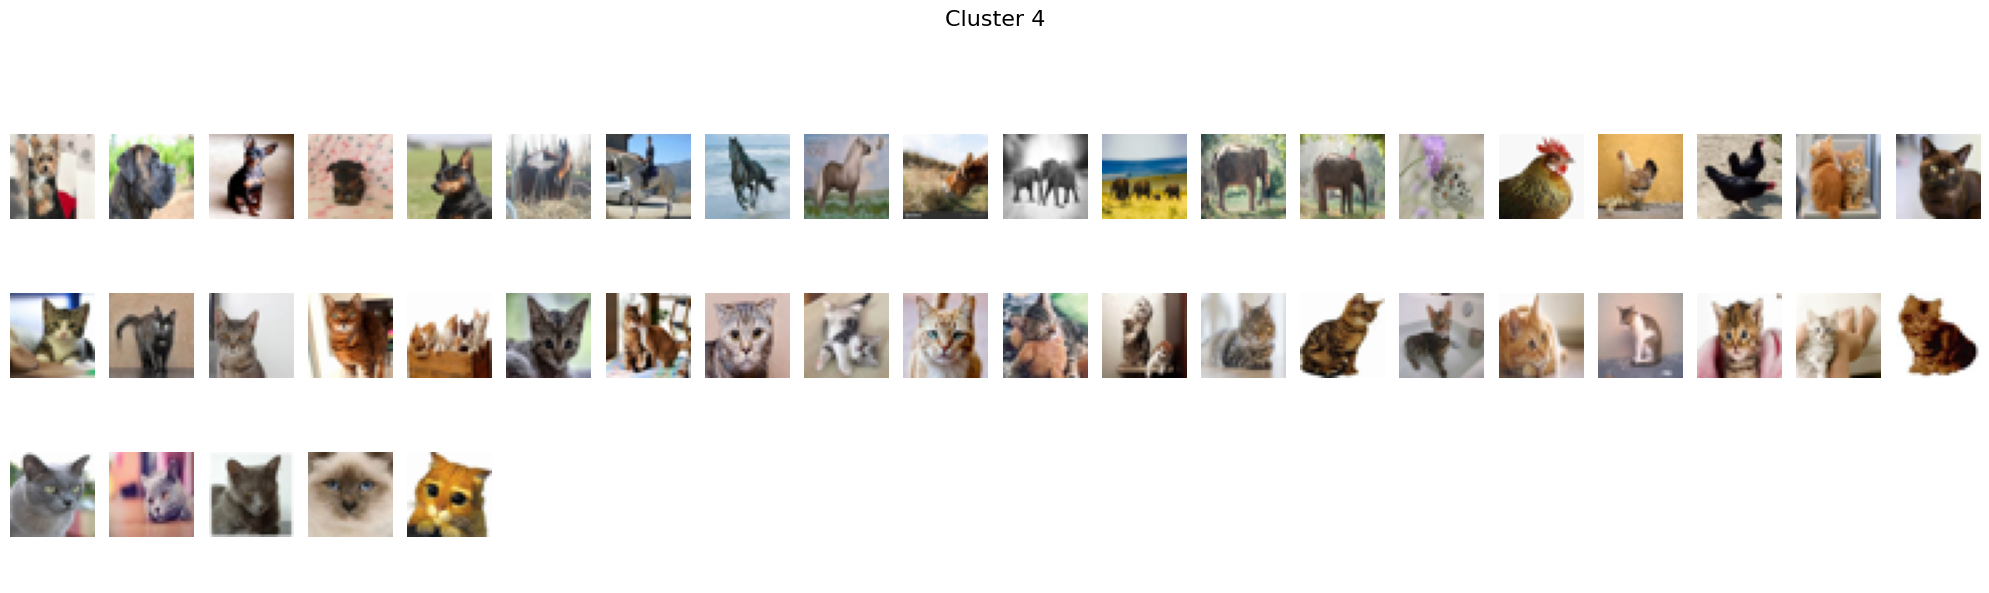

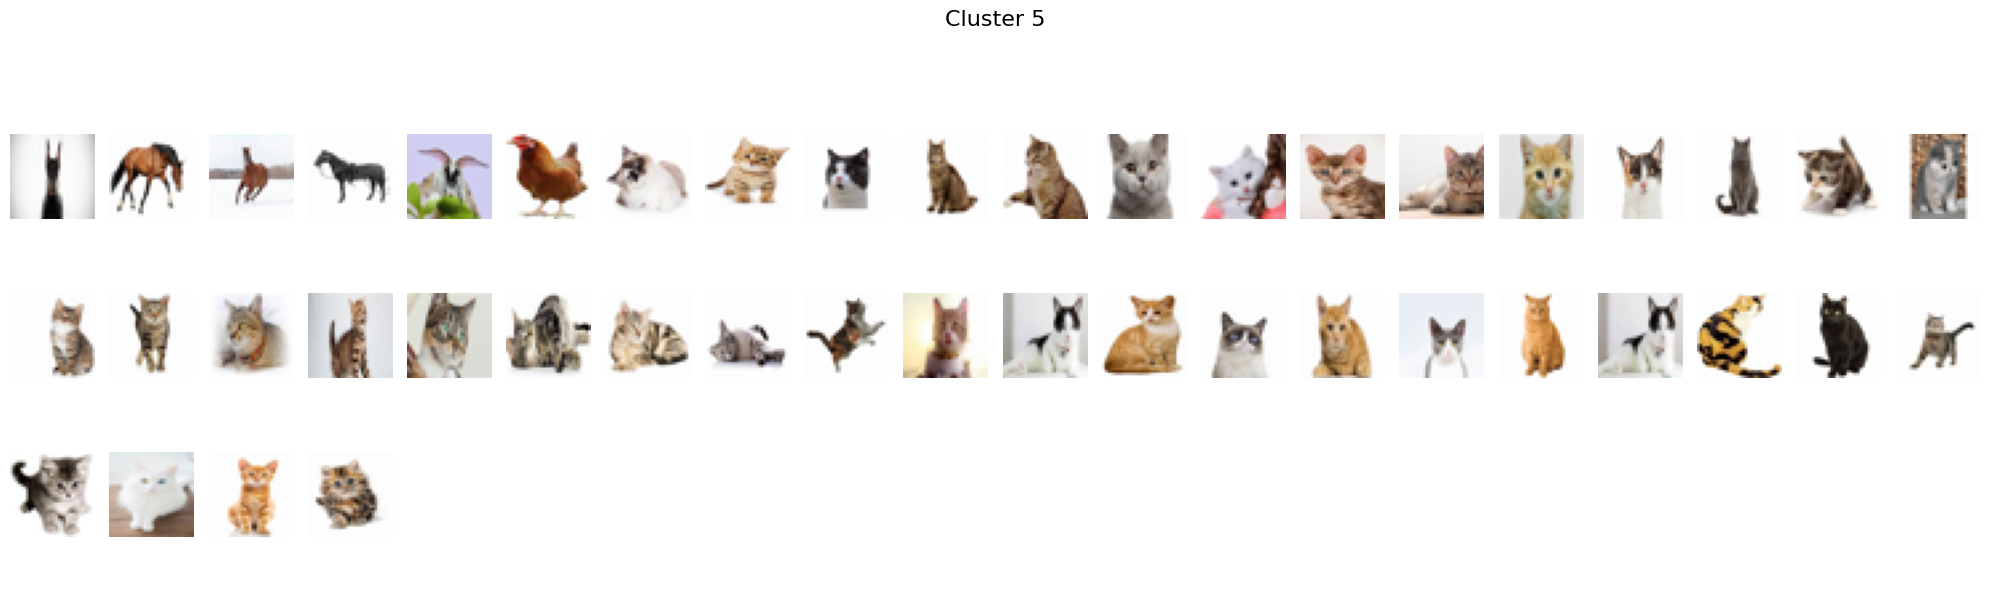

In [169]:
clustered_images = {}
num_clusters = 6

for i in range(num_clusters):
    clustered_images[i] = images[clusters == i]

def plot_cluster_images(clustered_images, cluster_id, images_per_row=20):
    """ Plot all images in a specified cluster with `images_per_row` images per row. """
    images = clustered_images[cluster_id]
    num_images = len(images)
    num_rows = (num_images + images_per_row - 1) // images_per_row 

    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(20, 2 * num_rows))
    if num_rows == 1:
        axes = np.array([axes])

    for i in range(num_images):
        ax = axes.flatten()[i]
        ax.imshow(images[i])
        ax.axis('off')

    for j in range(num_images, len(axes.flatten())):
        axes.flatten()[j].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.suptitle(f'Cluster {cluster_id}', fontsize=16, y=0.98)
    plt.show()

for cluster_id in range(num_clusters):
    plot_cluster_images(clustered_images, cluster_id)




5. Ensemble model, in mlp accuracy was near 36 percent, cnn gave 17 percent and ensemble gave 20 percent accuracy

In [2]:
class TreeNode():
    def __init__(self, data, feature_idx, feature_val, prediction_probs, information_gain) -> None:
        self.data = data
        self.feature_idx = feature_idx
        self.feature_val = feature_val
        self.prediction_probs = prediction_probs
        self.information_gain = information_gain
        self.feature_importance = self.data.shape[0] * self.information_gain
        self.left = None
        self.right = None

    def node_def(self) -> str:

        if (self.left or self.right):
            return f"NODE | Information Gain = {self.information_gain} | Split IF X[{self.feature_idx}] < {self.feature_val} THEN left O/W right"
        else:
            unique_values, value_counts = np.unique(self.data[:,-1], return_counts=True)
            output = ", ".join([f"{value}->{count}" for value, count in zip(unique_values, value_counts)])            
            return f"LEAF | Label Counts = {output} | Pred Probs = {self.prediction_probs}"

In [3]:
from collections import Counter
class DecisionTree():

    def __init__(self, max_depth=4, min_samples_leaf=1, 
                 min_information_gain=0.0, numb_of_features_splitting=None,
                 amount_of_say=None) -> None:
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_information_gain = min_information_gain
        self.numb_of_features_splitting = numb_of_features_splitting
        self.amount_of_say = amount_of_say

    def _entropy(self, class_probabilities: list) -> float:
        return sum([-p * np.log2(p) for p in class_probabilities if p>0])
    
    def _class_probabilities(self, labels: list) -> list:
        total_count = len(labels)
        return [label_count / total_count for label_count in Counter(labels).values()]

    def _data_entropy(self, labels: list) -> float:
        return self._entropy(self._class_probabilities(labels))
    
    def _partition_entropy(self, subsets: list) -> float:
        total_count = sum([len(subset) for subset in subsets])
        return sum([self._data_entropy(subset) * (len(subset) / total_count) for subset in subsets])
    
    def _split(self, data: np.array, feature_idx: int, feature_val: float) -> tuple:
        
        mask_below_threshold = data[:, feature_idx] < feature_val
        group1 = data[mask_below_threshold]
        group2 = data[~mask_below_threshold]

        return group1, group2
    
    def _select_features_to_use(self, data: np.array) -> list:
        feature_idx = list(range(data.shape[1]-1))

        if self.numb_of_features_splitting == "sqrt":
            feature_idx_to_use = np.random.choice(feature_idx, size=int(np.sqrt(len(feature_idx))))
        elif self.numb_of_features_splitting == "log":
            feature_idx_to_use = np.random.choice(feature_idx, size=int(np.log2(len(feature_idx))))
        else:
            feature_idx_to_use = feature_idx

        return feature_idx_to_use
        
    def _find_best_split(self, data: np.array) -> tuple:
        min_part_entropy = 1e9
        feature_idx_to_use =  self._select_features_to_use(data)

        for idx in feature_idx_to_use:
            feature_vals = np.percentile(data[:, idx], q=np.arange(25, 100, 25))
            for feature_val in feature_vals:
                g1, g2, = self._split(data, idx, feature_val)
                part_entropy = self._partition_entropy([g1[:, -1], g2[:, -1]])
                if part_entropy < min_part_entropy:
                    min_part_entropy = part_entropy
                    min_entropy_feature_idx = idx
                    min_entropy_feature_val = feature_val
                    g1_min, g2_min = g1, g2

        return g1_min, g2_min, min_entropy_feature_idx, min_entropy_feature_val, min_part_entropy

    def _find_label_probs(self, data: np.array) -> np.array:

        labels_as_integers = data[:,-1].astype(int)
        total_labels = len(labels_as_integers)
        label_probabilities = np.zeros(len(self.labels_in_train), dtype=float)
        for i, label in enumerate(self.labels_in_train):
            label_index = np.where(labels_as_integers == i)[0]
            if len(label_index) > 0:
                label_probabilities[i] = len(label_index) / total_labels

        return label_probabilities

    def _create_tree(self, data: np.array, current_depth: int) -> TreeNode:

        if current_depth > self.max_depth:
            return None
        
        split_1_data, split_2_data, split_feature_idx, split_feature_val, split_entropy = self._find_best_split(data)
        label_probabilities = self._find_label_probs(data)
        node_entropy = self._entropy(label_probabilities)
        information_gain = node_entropy - split_entropy
        
        node = TreeNode(data, split_feature_idx, split_feature_val, label_probabilities, information_gain)

        if self.min_samples_leaf > split_1_data.shape[0] or self.min_samples_leaf > split_2_data.shape[0]:
            return node
        elif information_gain < self.min_information_gain:
            return node

        current_depth += 1
        node.left = self._create_tree(split_1_data, current_depth)
        node.right = self._create_tree(split_2_data, current_depth)
        
        return node
    
    def _predict_one_sample(self, X: np.array) -> np.array:
        node = self.tree

        while node:
            pred_probs = node.prediction_probs
            if X[node.feature_idx] < node.feature_val:
                node = node.left
            else:
                node = node.right

        return pred_probs

    def train(self, X_train: np.array, Y_train: np.array) -> None:
        
        self.labels_in_train = np.unique(Y_train)
        train_data = np.concatenate((X_train, np.reshape(Y_train, (-1, 1))), axis=1)

        self.tree = self._create_tree(data=train_data, current_depth=0)

        self.feature_importances = dict.fromkeys(range(X_train.shape[1]), 0)
        self._calculate_feature_importance(self.tree)
        self.feature_importances = {k: v / total for total in (sum(self.feature_importances.values()),) for k, v in self.feature_importances.items()}

    def predict_proba(self, X_set: np.array) -> np.array:

        pred_probs = np.apply_along_axis(self._predict_one_sample, 1, X_set)
        
        return pred_probs

    def predict(self, X_set: np.array) -> np.array:

        pred_probs = self.predict_proba(X_set)
        preds = np.argmax(pred_probs, axis=1)
        
        return preds    
        
    def _print_recursive(self, node: TreeNode, level=0) -> None:
        if node != None:
            self._print_recursive(node.left, level + 1)
            print('    ' * 4 * level + '-> ' + node.node_def())
            self._print_recursive(node.right, level + 1)

    def print_tree(self) -> None:
        self._print_recursive(node=self.tree)

    def _calculate_feature_importance(self, node):
        if node != None:
            self.feature_importances[node.feature_idx] += node.feature_importance
            self._calculate_feature_importance(node.left)
            self._calculate_feature_importance(node.right)         

In [4]:

class RandomForestClassifier():
    def __init__(self, n_base_learner=10, max_depth=5, min_samples_leaf=1, min_information_gain=0.0, \
                 numb_of_features_splitting=None, bootstrap_sample_size=None) -> None:
        self.n_base_learner = n_base_learner
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_information_gain = min_information_gain
        self.numb_of_features_splitting = numb_of_features_splitting
        self.bootstrap_sample_size = bootstrap_sample_size

    def _create_bootstrap_samples(self, X, Y) -> tuple:
        bootstrap_samples_X = []
        bootstrap_samples_Y = []

        for i in range(self.n_base_learner):
            
            if not self.bootstrap_sample_size:
                self.bootstrap_sample_size = X.shape[0]
            
            sampled_idx = np.random.choice(X.shape[0], size=self.bootstrap_sample_size, replace=True)
            bootstrap_samples_X.append(X[sampled_idx])
            bootstrap_samples_Y.append(Y[sampled_idx])

        return bootstrap_samples_X, bootstrap_samples_Y

    def train(self, X_train: np.array, Y_train: np.array) -> None:
        """Trains the model with given X and Y datasets"""
        bootstrap_samples_X, bootstrap_samples_Y = self._create_bootstrap_samples(X_train, Y_train)

        self.base_learner_list = []
        for base_learner_idx in range(self.n_base_learner):
            base_learner = DecisionTree(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf, \
                                        min_information_gain=self.min_information_gain, 
                                        numb_of_features_splitting=self.numb_of_features_splitting)
            
            base_learner.train(bootstrap_samples_X[base_learner_idx], bootstrap_samples_Y[base_learner_idx])
            self.base_learner_list.append(base_learner)
        self.feature_importances = self._calculate_rf_feature_importance(self.base_learner_list)

    def _predict_proba_w_base_learners(self,  X_set: np.array) -> list:
        pred_prob_list = []
        for base_learner in self.base_learner_list:
            pred_prob_list.append(base_learner.predict_proba(X_set))

        return pred_prob_list

    def predict_proba(self, X_set: np.array) -> list:

        pred_probs = []
        base_learners_pred_probs = self._predict_proba_w_base_learners(X_set)

        for obs in range(X_set.shape[0]):
            base_learner_probs_for_obs = [a[obs] for a in base_learners_pred_probs]
            obs_average_pred_probs = np.mean(base_learner_probs_for_obs, axis=0)
            pred_probs.append(obs_average_pred_probs)

        return pred_probs

    def predict(self, X_set: np.array) -> np.array:

        pred_probs = self.predict_proba(X_set)
        preds = np.argmax(pred_probs, axis=1)
        
        return preds
    
    def _calculate_rf_feature_importance(self, base_learners):
        feature_importance_dict_list = []
        for base_learner in base_learners:
            feature_importance_dict_list.append(base_learner.feature_importances)

        feature_importance_list = [list(x.values()) for x in feature_importance_dict_list]
        average_feature_importance = np.mean(feature_importance_list, axis=0)

        return average_feature_importance

In [6]:
data_x = np.load('datatree.npz')['data']
data_y = np.load('datatree.npz')['labels']
train_x =np.array(data_x,dtype = 'float')/255.0
train_x.shape

(26179, 25, 25, 3)

In [7]:
train_x = np.reshape(train_x, (26179, 25*25*3))

In [8]:
labels = dict({'cane':0,
               'cavallo':1,
               'elefante':2,
               'farfalla':3,
               'gallina':4,
               'gatto':5,
               'mucca':6,
               'pecora':7,
               'ragno':8,
               'scoiattolo':9})
y = np.zeros(len(data_y),dtype = int)
for i in range(data_y.shape[0]):
    y[i] = labels[data_y[i]]
train_y=y

In [9]:
def calculate_accuracy(true_class, predicted_y):
  accuracy = np.mean(np.equal(true_class, predicted_y))
  return accuracy

In [12]:
train_x,train_y,valx,valy,test_x,test_y = randomised_trainingset(train_x,train_y)

trainx = train_x[:2000]
trainy = train_y[:2000]
testx= test_x[:1000]
testy = test_y[:1000]

In [14]:
pca = PCA(30)
pca.fit(trainx)
print(f"Explained variance: {pca.variance_share:.4f}")
trainx =pca.transform(trainx)
print(trainx.shape)

Explained variance: 0.7026
(2000, 30)


In [15]:
testx = pca.transform(testx)
rtree = RandomForestClassifier()
rtree.train(trainx, trainy)

In [22]:
predicted_y=rtree.predict(testx)
acc= calculate_accuracy(testy,predicted_y)
f1 = f1_score(testy,predicted_y)
print(f"acc is {acc*100} and f1 score is {f1}") 

acc is 20.200000000000003 and f1 score is 0.7163120567375887


6) Extract the features from a pre-trained Imagenet, append and train an MLP on top of it.

In [1]:
import torch
import torchvision as vision
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from PIL import Image
import os


/data/home1/rishavs/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading the resnet model, and removing the last layer to get the features which has to be passed into the MLP.

In [2]:
resnet18 = models.resnet18(pretrained=True)

resnet18 = torch.nn.Sequential(*(list(resnet18.children())[:-1]))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.eval()


/data/home1/rishavs/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/home1/rishavs/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [9]:
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL image
    transforms.Resize((224, 224)),  # Resize images to ResNet-18 input size
    transforms.ToTensor(),  # Convert PIL images to tensors
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Normalize images
        std=[0.229, 0.224, 0.225]
    )
])


data_x = np.load('data.npz')['data']
data_y = np.load('data.npz')['labels']
train_x =np.array(data_x,dtype = 'float')/255.0

labels = dict({'cane':0,
               'cavallo':1,
               'elefante':2,
               'farfalla':3,
               'gallina':4,
               'gatto':5,
               'mucca':6,
               'pecora':7,
               'ragno':8,
               'scoiattolo':9})
y = np.zeros(len(data_y),dtype = int)
for i in range(data_y.shape[0]):
    y[i] = labels[data_y[i]]
train_y=y 

In [13]:
features = []
for img in train_x:
    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0)
    img_tensor = img_tensor.to(device)
    
    with torch.no_grad():
        output = resnet18(img_tensor)
    features.append(output.squeeze().cpu().numpy())

In [14]:
features = torch.tensor(features)

/tmp/ipykernel_1318632/787745083.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  features = torch.tensor(features)


In [15]:
features.shape

torch.Size([26179, 512])

In [16]:
features_array = features.numpy()

In [17]:
features_array.shape

(26179, 512)

In [18]:
train_x = features_array

In [19]:
def randomised_trainingset(setx,sety): 
    total,r = setx.shape
    train = int(total*0.7)
    test = total-train
    
    trainx = np.zeros((train,r))
    trainy = np.zeros(train,dtype=int)
    testx = np.zeros((test,r))
    testy = np.zeros(test,dtype=int)
    
    indices =  np.random.permutation(total)
    trainx = np.take(setx, indices[:train],axis=0)
    trainy = np.take(sety, indices[:train])
    testx = np.take(setx, indices[train:],axis=0)
    testy = np.take(sety, indices[train:])
    
    
    return trainx,trainy,testx,testy

In [20]:
train_x,train_y,test_x,test_y = randomised_trainingset(train_x,train_y)

In [23]:
trainx = train_x
trainy = train_y
testx= test_x
testy = test_y

In [26]:
pca = PCA(30)
pca.fit(trainx)
print(f"Explained variance: {pca.variance_share:.4f}")
trainx =pca.transform(trainx) #reducing the features
print(trainx.shape)

Explained variance: 0.5573
(18325, 30)


In [33]:
testx = pca.transform(testx)

In [36]:
def one_hot_encode(labels): 
    unique_labels = np.unique(labels)
    num_labels = len(unique_labels)
    encoding = np.zeros((len(labels), num_labels), dtype=int)
    for i, label in enumerate(labels):
        index = np.arange(num_labels)[unique_labels == label][0]
        encoding[i, index] = 1
    return encoding

trainy = one_hot_encode(trainy).T
testy = one_hot_encode(testy).T

In [41]:
trainx = trainx.T
testx = testx.T

Using MLP coded in the 2nd Assignment

In [42]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def softmax(x):
    shifted_x = x - np.max(x, axis=0, keepdims=True) 
    exp_scores = np.exp(shifted_x)
    softmax_probs = exp_scores / np.sum(exp_scores, axis=0, keepdims=True)
    return softmax_probs

def initialize_parameters(input_size, hidden_sizes, output_size):
    np.random.seed(0)
    parameters = {}
    prev_size = input_size
    for i, hidden_size in enumerate(hidden_sizes):
        parameters[f'W{i+1}'] = np.random.randn(hidden_size, prev_size) * np.sqrt(1/prev_size)
        prev_size = hidden_size
    parameters[f'W{len(hidden_sizes)+1}'] = np.random.randn(output_size, prev_size) * np.sqrt(1/prev_size) 
    return parameters
def update_parameters(parameters, gradients, learning_rate):
    for key in parameters.keys():
        parameters[key] -= learning_rate * gradients[f'd{key}']
    return parameters

def forward_propagation_multiclass(X, parameters):
    temp = {'A0': X}
    for i, key in enumerate(parameters.keys()):
        W = parameters[key]
        Z = np.dot(W, temp[f'A{i}'])
        if i < len(parameters) - 1:
            A = relu(Z)
        else:
            A = softmax(Z)
        temp[f'Z{i+1}'] = Z
        temp[f'A{i+1}'] = A
    return temp


def cross_entropy_loss(Y, Y_pred):
    m = Y.shape[1]
    epsilon = 1e-10
    Y_pred = np.clip(Y_pred, epsilon, 1 - epsilon)
    loss = -1/m * np.sum(Y * np.log(Y_pred))
    return loss

def backward_propagation_multiclass(X, Y, parameters, temp): 
        gradients = {}
        dZ = temp[f'A{len(parameters)}'] - Y 
        for i in range(len(parameters), 0, -1):
            A_prev = temp[f'A{i-1}']
            gradients[f'dW{i}'] = np.dot(dZ, A_prev.T)
            if i > 1:
                W = parameters[f'W{i}']
                dZ = np.dot(W.T, dZ) * relu_derivative(temp[f'Z{i-1}'])
        return gradients

def predict_multiclass(X, parameters):
    temp = forward_propagation_multiclass(X, parameters)
    final_output = temp[f'A{len(parameters)}']
    predictions = np.argmax(final_output, axis=0)
    return predictions

def train_multiclass(X, Y, input_size, hidden_sizes, output_size, learning_rate, num_iterations, batch_size):
    parameters = initialize_parameters(input_size, hidden_sizes, output_size)
    for i in range(num_iterations):
        for j in range(0, X.shape[1], batch_size):
                X_batch = X[:, j:j+batch_size]
                Y_batch = Y[:, j:j+batch_size]
                temp = forward_propagation_multiclass(X_batch,parameters)
        
        loss_ce = cross_entropy_loss(Y_batch, temp[f'A{len(parameters)}'])
        gradients = backward_propagation_multiclass(X_batch, Y_batch, parameters, temp)
        parameters = update_parameters(parameters, gradients, learning_rate)
        if i % 100 == 0:
            print(f'Iteration {i}, Loss: {loss_ce}')
    return parameters

In [46]:
hidden_sizes = [128,128]
input_size = 30
output_size = 10
parameters = train_multiclass(trainx,trainy, input_size, hidden_sizes, output_size, learning_rate=0.001, num_iterations=500, batch_size=256)

predictions = predict_multiclass(testx, parameters)

accuracy = np.mean(predictions == testy)
print(f"Accuracy on testing data: {accuracy*100}%") 

Iteration 0, Loss: 4.3576792419414465
Iteration 100, Loss: 0.013010295536838927
Iteration 200, Loss: 0.004864575371008624
Iteration 300, Loss: 0.002815922002083025
Iteration 400, Loss: 0.001935572807442835
Accuracy on testing data: 26.796536796536795%


# Text Tasks

1. MLP

In [63]:
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    exp_scores = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

class NeuralNetwork2:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.output_size = output_size
        self.W1 = np.random.randn(self.input_size, self.hidden_size1) * 0.01
        self.b1 = np.zeros((1, self.hidden_size1))
        self.W2 = np.random.randn(self.hidden_size1, self.hidden_size2) * 0.01
        self.b2 = np.zeros((1, self.hidden_size2))
        self.W3 = np.random.randn(self.hidden_size2, self.output_size) * 0.01
        self.b3 = np.zeros((1, self.output_size))

    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = relu(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = relu(self.z2)
        self.z3 = np.dot(self.a2, self.W3) + self.b3
        self.probs = softmax(self.z3)
        return self.probs

    def backward(self, X, y, learning_rate=0.01):
        m = X.shape[0]
        d_z3 = self.probs - y
        d_W3 = np.dot(self.a2.T, d_z3)
        d_b3 = np.sum(d_z3, axis=0, keepdims=True)
        d_a2 = np.dot(d_z3, self.W3.T)
        d_z2 = d_a2 * (self.a2 > 0)
        d_W2 = np.dot(self.a1.T, d_z2)
        d_b2 = np.sum(d_z2, axis=0, keepdims=True)
        d_a1 = np.dot(d_z2, self.W2.T)
        d_z1 = d_a1 * (self.a1 > 0)
        d_W1 = np.dot(X.T, d_z1)
        d_b1 = np.sum(d_z1, axis=0, keepdims=True)

        self.W1 -= learning_rate * d_W1
        self.b1 -= learning_rate * d_b1
        self.W2 -= learning_rate * d_W2
        self.b2 -= learning_rate * d_b2
        self.W3 -= learning_rate * d_W3
        self.b3 -= learning_rate * d_b3
    

In [74]:
input_size = 32914 
hidden_size1 = 512 
hidden_size2 = 128 
output_size = 12  
learning_rate = 0.001

model = NeuralNetwork2(input_size, hidden_size1, hidden_size2, output_size)

def train(X_train,y_train):
    
    epochs = 10 
    
    for epoch in range(epochs):
        print(f"Epoch {epoch}")
        y_pred= model.forward(X_train)
        model.backward(X_train, y_train, learning_rate=learning_rate)
        loss = cross_entropy_loss(y_train,y_pred)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss}')

In [75]:
train(X_train_without_embedding[:5000,],y_train)

Epoch 0
Epoch 1/10, Loss: 0.286836407741278
Epoch 1
Epoch 2/10, Loss: 0.28673387265121864
Epoch 2
Epoch 3/10, Loss: 0.2866985286073181
Epoch 3
Epoch 4/10, Loss: 0.2866859747367186
Epoch 4
Epoch 5/10, Loss: 0.2866813853099308
Epoch 5
Epoch 6/10, Loss: 0.28667961696443345
Epoch 6
Epoch 7/10, Loss: 0.2866788744754116
Epoch 7
Epoch 8/10, Loss: 0.28667853258006926
Epoch 8
Epoch 9/10, Loss: 0.2866783431084662
Epoch 9
Epoch 10/10, Loss: 0.28667821358296824


In [76]:
test_out=model.forward(X_test_without_ebedding[:5000])

In [77]:
calculate_accuracy(test_out,y_test[:5000])

8.38


2. Self attention

In [30]:
import numpy as np
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import matplotlib.pyplot as plt

This code reads data from a JSON file containing news articles. It iterates through each line of the file, parses it as JSON, and extracts the category information from each article into a list called news_category

In [31]:
FILE_PATH="News_Category_Dataset_v3.json"
news=[]
news_headlines=[]
news_category=[]
count=0
with open(FILE_PATH,'r') as file:
    for line in file:
        line=json.loads(line)
        news_category.append(line['category'])


In [32]:
news_category_count={}
for category in np.unique(news_category):
    news_category_count[category]=news_category.count(category)

 Sorting the news category in descending order on he basis of data available

In [33]:
sorted_dict = dict(sorted(news_category_count.items(), key=lambda item: item[1], reverse=True))
unique_12_news_category=[]
count=0
for key in sorted_dict.keys():
    if count<12:
        unique_12_news_category.append(key)
        count+=1
unique_12_news_category

['POLITICS',
 'WELLNESS',
 'ENTERTAINMENT',
 'TRAVEL',
 'STYLE & BEAUTY',
 'PARENTING',
 'HEALTHY LIVING',
 'QUEER VOICES',
 'FOOD & DRINK',
 'BUSINESS',
 'COMEDY',
 'SPORTS']

In [34]:
news_headlines_12=[]
news_category_12=[]
with open(FILE_PATH,'r') as file_2:
    for line in file_2:
        line=json.loads(line)
        if line['category'] in unique_12_news_category:
            news_headlines_12.append(line['headline'])
            news_category_12.append(line['category'])

In [35]:
np.unique(news_category_12)

array(['BUSINESS', 'COMEDY', 'ENTERTAINMENT', 'FOOD & DRINK',
       'HEALTHY LIVING', 'PARENTING', 'POLITICS', 'QUEER VOICES',
       'SPORTS', 'STYLE & BEAUTY', 'TRAVEL', 'WELLNESS'], dtype='<U14')

In [36]:
len(news_headlines_12)

135264

 Checking that the data is hughly imabalanced , so clip the data for all categories to the lowest data category

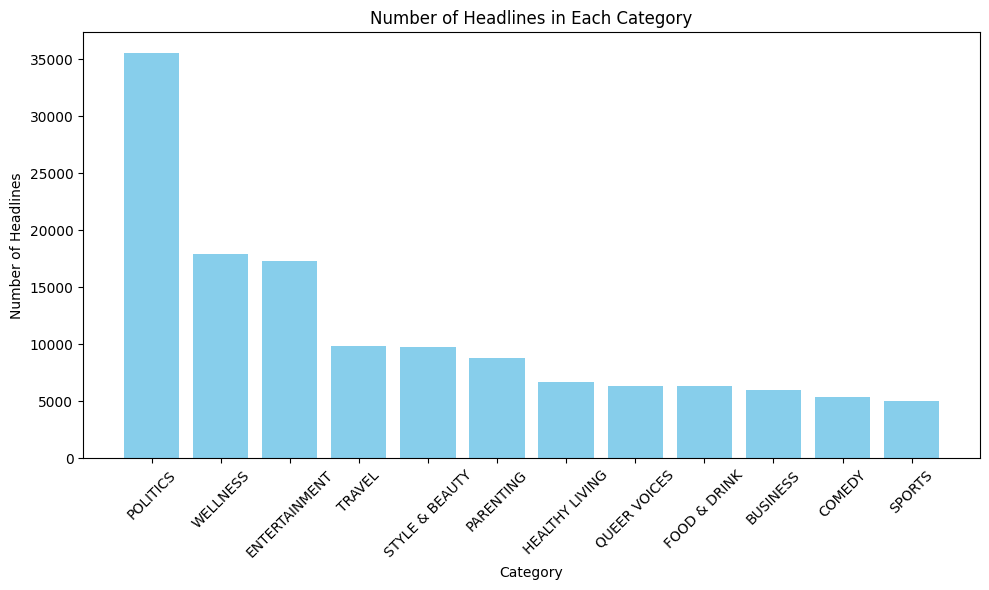

In [37]:
category_counts = {}
for category in unique_12_news_category:
    
    category_counts[category] = news_category.count(category)

plt.figure(figsize=(10, 6))
plt.bar(category_counts.keys(), category_counts.values(), color='skyblue')
plt.title('Number of Headlines in Each Category')
plt.xlabel('Category')
plt.ylabel('Number of Headlines')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The data is imbalanced . So we will clip the data to make it balanced

In [38]:
import random
min_news_data=news_category_12.count('SPORTS')
np.unique(news_category_12)

array(['BUSINESS', 'COMEDY', 'ENTERTAINMENT', 'FOOD & DRINK',
       'HEALTHY LIVING', 'PARENTING', 'POLITICS', 'QUEER VOICES',
       'SPORTS', 'STYLE & BEAUTY', 'TRAVEL', 'WELLNESS'], dtype='<U14')

In [39]:
headlines_by_category = {}

for headline, category in zip(news_headlines_12, news_category_12):
    if category not in headlines_by_category:
        headlines_by_category[category] = []
    headlines_by_category[category].append(headline)

selected_headlines = {}

for category, headlines_list in headlines_by_category.items():
    selected_headlines[category] = headlines_list[:5000]

In [40]:
len(selected_headlines['SPORTS'])

5000

In [41]:
final_news_headlines=[]
final_news_category=[]

for key,value in selected_headlines.items():
    num_of_headlines=len(value)
    final_news_headlines.append(value)
    for i in range(num_of_headlines):
        final_news_category.append(key)


In [42]:
final_news_headlines = [item for sublist in final_news_headlines for item in sublist]
len(final_news_headlines)
final_news_category[4999]

'COMEDY'

 randomly shuffling the data

In [43]:
combined_list = list(zip(final_news_headlines, final_news_category))

random.shuffle(combined_list)

final_news_headlines = [pair[0] for pair in combined_list]
final_news_category = [pair[1] for pair in combined_list]


In [44]:
word_embedder=TfidfVectorizer()
embeddings=word_embedder.fit_transform(final_news_headlines)
data=embeddings.toarray()
target=np.array(final_news_category)

In [45]:
len(np.unique(target))

12

 one hot encoding the data

In [46]:
one_hot_encoder=LabelBinarizer()
target=one_hot_encoder.fit_transform(target)
target

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [47]:
train_size=0.7
total_data_points=len(data)
training_data_size=int(train_size*total_data_points)
X_train_without_embedding=data[:training_data_size,:]
X_test_without_ebedding=data[training_data_size:,:]
y_train=target[:training_data_size]
y_test=target[training_data_size:]

 Performing the positional encoding as per the transformer paper

In [48]:
def positional_encoding(tfidf_matrix, d_model):
    num_docs, num_features = tfidf_matrix.shape
    pos_encodings = np.zeros((num_docs, d_model))
    positions = np.arange(0, num_docs)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    
    pos_encodings[:, 0::2] = np.sin(positions * div_term)
    pos_encodings[:, 1::2] = np.cos(positions * div_term)
    pos_tfidf_encodings = np.concatenate((tfidf_matrix, pos_encodings), axis=1)
    
    return pos_tfidf_encodings

d_model = 32
pos_tfidf_encodings = positional_encoding(data, d_model)
print("Positional Encodings with TF-IDF:")
print(pos_tfidf_encodings)


Positional Encodings with TF-IDF:
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  9.99999950e-01
   1.77827940e-04  9.99999984e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  9.99999800e-01
   3.55655875e-04  9.99999937e-01]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  9.92425222e-01
  -9.47192726e-01 -3.20664841e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  9.92386324e-01
  -9.47249734e-01 -3.20496399e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  9.92347327e-01
  -9.47306712e-01 -3.20327946e-01]]


In [49]:
train_size=0.7
total_data_points=len(pos_tfidf_encodings)
training_data_size=int(train_size*total_data_points)
X_train=pos_tfidf_encodings[:training_data_size,:]
X_test=pos_tfidf_encodings[training_data_size:,:]
y_train=target[:training_data_size]
y_test=target[training_data_size:]

In [50]:
X_train.shape

(42000, 32946)

In [51]:
pos_tfidf_encodings.shape

(60000, 32946)

In [52]:
any(X_train[0]==X_train[1])

True

 Self Attention Block

In [53]:
LEARNING_RATE=0.001
class SelfAttentionModule:
    def __init__(self,input_dim,d_k):
        self.input_dim=input_dim 
        self.d_k=d_k
        self.W_Q=np.random.randn(self.input_dim,self.d_k) 
        self.W_K=np.random.randn(self.input_dim,self.d_k)
        self.W_V=np.random.randn(self.input_dim,self.d_k)
    def forward(self,X_train):
        self.X_train=X_train
        self.query_matrix=np.dot(X_train,self.W_Q)
        self.value_matrix=np.dot(X_train,self.W_V)
        self.key_matrix=np.dot(X_train,self.W_K)
        self.H_matrix=softmax(np.matmul(self.query_matrix,self.key_matrix.T)/np.sqrt(self.d_k))
        self.final_output=np.matmul(self.H_matrix,self.value_matrix)
        print(self.H_matrix.shape)
        return self.final_output

    def backward(self,prev_gradient):
        self.W_V_grad = self.X_train.T @ self.H_matrix.T @ prev_gradient 
        self.W_K_grad = (1/np.sqrt(self.d_k))* self.X_train.T @ (np.multiply(self.H_matrix,(prev_gradient @ self.value_matrix.T))).T @ (self.query_matrix- (self.H_matrix @ self.query_matrix))


        temp = np.multiply(self.H_matrix, np.matmul(prev_gradient, self.value_matrix.T)) - np.multiply(
            np.sum(np.multiply(self.H_matrix, np.matmul(prev_gradient, self.value_matrix.T)), axis=1), self.H_matrix)
        self.W_Q_grad = (1 / np.sqrt(self.d_k)) * np.matmul(np.matmul(self.X_train.T, temp), self.key_matrix)
        return self.W_K_grad,self.W_Q_grad,self.W_V_grad

In [55]:
X_train.shape

(42000, 32946)

### Creating a neural network for classification

In [56]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.output_size = output_size

        self.W1 = np.random.randn(self.input_size, self.hidden_size1) * 0.01
        self.b1 = np.zeros((1, self.hidden_size1))
        self.W2 = np.random.randn(self.hidden_size1, self.hidden_size2) * 0.01
        self.b2 = np.zeros((1, self.hidden_size2))
        self.W3 = np.random.randn(self.hidden_size2, self.output_size) * 0.01
        self.b3 = np.zeros((1, self.output_size))

    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = relu(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = relu(self.z2)
        self.z3 = np.dot(self.a2, self.W3) + self.b3
        self.probs = softmax(self.z3)
        return self.probs

    def backward(self, X, y, learning_rate=0.01):
        m = X.shape[0]
        d_z3 = self.probs - y
        d_W3 = np.dot(self.a2.T, d_z3)
        d_b3 = np.sum(d_z3, axis=0, keepdims=True)
        d_a2 = np.dot(d_z3, self.W3.T)
        d_z2 = d_a2 * (self.a2 > 0)
        d_W2 = np.dot(self.a1.T, d_z2)
        d_b2 = np.sum(d_z2, axis=0, keepdims=True)
        d_a1 = np.dot(d_z2, self.W2.T)
        d_z1 = d_a1 * (self.a1 > 0)
        d_W1 = np.dot(X.T, d_z1)
        d_b1 = np.sum(d_z1, axis=0, keepdims=True)

        self.W1 -= learning_rate * d_W1
        self.b1 -= learning_rate * d_b1
        self.W2 -= learning_rate * d_W2
        self.b2 -= learning_rate * d_b2
        self.W3 -= learning_rate * d_W3
        self.b3 -= learning_rate * d_b3
        prev_gradient = np.dot(d_z1, self.W1.T)
        return prev_gradient


In [57]:
def cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-12
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon) 
    
    loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    return loss


 Training and testing the whole attention and neural network

In [59]:
X_train=X_train[:5000,]
y_train=y_train[:5000,]
EPOCHS=10
LEARNING_RATE=0.001
attentionModel=SelfAttentionModule(input_dim=X_train.shape[1],d_k=50)
classifier=NeuralNetwork(50,128,128,12)
for epoch in range(EPOCHS):
    attention_output=attentionModel.forward(X_train)
    classifier_output=classifier.forward(attention_output)
    loss=cross_entropy_loss(y_train,classifier_output)
    classifier_prev_gradient=classifier.backward(attention_output,y_train,LEARNING_RATE)
    d_K,d_Q,d_V=attentionModel.backward(classifier_prev_gradient)
    attentionModel.W_Q -= LEARNING_RATE * d_Q
    attentionModel.W_K -= LEARNING_RATE * d_K
    attentionModel.W_V -= LEARNING_RATE * d_V
    print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {loss}')

(5000, 5000)
Epoch 1/10, Loss: 0.2868370595243232
(5000, 5000)
Epoch 2/10, Loss: 0.2881294562489528
(5000, 5000)
Epoch 3/10, Loss: 0.29917588710781867
(5000, 5000)
Epoch 4/10, Loss: 0.3575387103420703
(5000, 5000)
Epoch 5/10, Loss: 0.498869978272432
(5000, 5000)
Epoch 6/10, Loss: 4.820159501413446
(5000, 5000)
Epoch 7/10, Loss: 5.236139110953668
(5000, 5000)
Epoch 8/10, Loss: 5.243046946192394
(5000, 5000)
Epoch 9/10, Loss: 5.236139110953668
(5000, 5000)
Epoch 10/10, Loss: 5.243046946192394


In [60]:
X_test=X_test
y_test=y_test
attention_test_output=attentionModel.forward(X_test)
classifier_test_output=classifier.forward(attention_test_output)

(18000, 18000)


In [61]:
def calculate_accuracy(y_pred, y_test):
    y_pred = np.array(y_pred)
    y_test = np.array(y_test)
    y_pred_argmax = np.argmax(y_pred, axis=1)
    y_argmax=np.argmax(y_test,axis=1)
    correct_predictions = np.sum(y_pred_argmax==y_argmax)
    
    accuracy = correct_predictions / len(y_test)
    return accuracy

In [62]:
calculate_accuracy(classifier_test_output,y_test)

8.094444444444445


3. random forest for text dataset

In [ ]:
import json
from sklearn.feature_extraction.text import TfidfVectorizer


def load_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    return data

data = load_data('/content/drive/MyDrive/News_Category_Dataset_v3.json')

categories = [item['category'] for item in data]
headlines = [item['headline'] for item in data]


In [ ]:
category_freq = {}
for item in data:
    category = item['category']
    if category in category_freq:
        category_freq[category] += 1
    else:
        category_freq[category] = 1

top_categories = sorted(category_freq, key=category_freq.get, reverse=True)[:12]
filtered_data = [item for item in data if item['category'] in top_categories]
headlines = [item['headline'] for item in filtered_data]
categories = [item['category'] for item in filtered_data]

unique_categories = list(set(categories))
category_to_id = {category: idx for idx, category in enumerate(unique_categories)}
y_encoded = np.array([category_to_id[category] for category in categories])


vectorizer = TfidfVectorizer(max_features=3000)  
X = vectorizer.fit_transform(headlines)


def train_test_split(X, y, test_size=0.2, random_state=42):
    np.random.seed(random_state)
    indices = np.random.permutation(len(y))
    test_size = int(len(y) * test_size)
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [ ]:
class DecisionTree:
    def __init__(self, max_depth, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def fit(self, X, y):
        self.tree = self.build_tree(X, y, depth=0)

    def build_tree(self, X, y, depth):
        num_samples, num_features = X.shape
        if num_samples == 0:
            return None 
        if depth >= self.max_depth or num_samples < self.min_samples_split or np.unique(y).size == 1:
            return np.bincount(y).argmax() if y.size > 0 else None

        best_feat, best_thresh = self.best_split(X, y)
        if best_feat is None: 
            return np.bincount(y).argmax() if y.size > 0 else None

        left_idxs, right_idxs = self.split(X[:, best_feat], best_thresh)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return np.bincount(y).argmax()

        left = self.build_tree(X[left_idxs], y[left_idxs], depth + 1)
        right = self.build_tree(X[right_idxs], y[right_idxs], depth + 1)
        return (best_feat, best_thresh, left, right)

    def best_split(self, X, y):
        num_samples, num_features = X.shape
        best_gain = -float('inf')
        best_feat = None
        best_thresh = None

        for feat_idx in range(num_features):
            X_column = X[:, feat_idx]
            if hasattr(X_column, "toarray"): 
                X_column = X_column.toarray().ravel()
            else:
                X_column = X_column.ravel()

            threshold = np.median(X_column)
            gain = self.calculate_information_gain(X_column, y, threshold)
            if gain > best_gain:
                best_gain = gain
                best_feat = feat_idx
                best_thresh = threshold

        return best_feat, best_thresh

    def calculate_information_gain(self, X_column, y, threshold):
        left_idxs = np.where(X_column <= threshold)[0]
        right_idxs = np.where(X_column > threshold)[0]

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0 

        parent_entropy = self.entropy(y)
        left_entropy = self.entropy(y[left_idxs])
        right_entropy = self.entropy(y[right_idxs])

        n = len(y)
        n_left, n_right = len(left_idxs), len(right_idxs)
        weighted_entropy = (n_left / n) * left_entropy + (n_right / n) * right_entropy
        information_gain = parent_entropy - weighted_entropy
        return information_gain

    def entropy(self, y):
        counts = np.bincount(y)
        probabilities = counts / counts.sum()
        entropy = -np.sum(probabilities * np.log2(probabilities + 1e-9)) 
        return entropy

    def split(self, X_column, threshold):
        if hasattr(X_column, 'toarray'):
            X_column = X_column.toarray().ravel()
        left_idxs = np.where(X_column <= threshold)[0]
        right_idxs = np.where(X_column > threshold)[0]
        return left_idxs, right_idxs

    def _predict(self, x, node):
        if not isinstance(node, tuple):
            return node
        feature, threshold, left, right = node
        
        if hasattr(x, 'toarray'): 
            x = x.toarray() 
        x_value = x[feature] if x.ndim == 1 else x[0, feature]

        if x_value <= threshold:
            return self._predict(x, left)
        else:
            return self._predict(x, right)


    def predict(self, X):
        if hasattr(X, 'toarray'):
            X = X.toarray() 
        return np.array([self._predict(x, self.tree) for x in X])

class RandomForest:
    def __init__(self, n_trees=10, max_depth=5):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        for _ in range(self.n_trees):
            tree = DecisionTree(self.max_depth)
            indices = np.random.choice(len(y), len(y), replace=True)
            subset_X = X[indices]
            subset_y = y[indices]
            tree.fit(subset_X, subset_y)
            self.trees.append(tree)

    def predict(self, X):
        predictions = [tree.predict(X) for tree in self.trees]
        predictions = np.array(predictions).T
        return np.apply_along_axis(lambda x: np.bincount(x, minlength=np.max(x)+1).argmax(), axis=1, arr=predictions)


forest = RandomForest(n_trees=20, max_depth=7)
forest.fit(X_train, y_train)
predictions = forest.predict(X_test)

accuracy = np.mean(predictions == y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.34685051012864115
